# Markov Decision Process (MDP)

MDPs provide the mathematical framework to define the idealized Reinforcement Learning problem:

<div>
  <img src="https://github.com/pranay8297/drl-zh/blob/main/assets/01_MDP_agent_env_diagram.png?raw=1">
  <br>
  <small>Drawing from Sutton and Barto, Reinforcement Learning: An Introduction, 2020</small>
</div>

**Reinforcement learning** algorithms enable the agent to learn to solve a control task (formulated
as an MDP) by trial and error, without any supervision, just interacting with the environment, and
receving feedback in the form of positive / negative rewards.

## MDP Formal Definition

* Set of states $S$
* Set of actions $A$
* Transition function $P(s'|s, a)$
* Reward function $R(s, a, s')$
* Initial state $s_0$
* Discount factor $\gamma$
* Horizon $H$ (how long we are going to be acting)

MDPs are **memoryless** (_Markov property_): we only need the current state to decide what action to
take next, and not the history of all the states and actions it took before.

## Hands-on Example: Grid World

<div>
  <img src="https://github.com/pranay8297/drl-zh/blob/main/assets/01_MDP_gridworld.png?raw=1">
  <br>
  <small>Picture from the U.C. Berkeley <a href="https://inst.eecs.berkeley.edu/~cs188/fa23/">
  CS 188</a> materials.</small>
</div>

### Let's create a basic _grid_ representation.

In [1]:


class Cell():
    """The type of cells in the Grid World."""
    START  = 'S'
    TARGET = 'T'
    EMPTY  = 'E'
    WALL   = 'W'
    BOMB   = 'B'

class Grid:
    """The definition of the grid in the Grid World."""

    def __init__(self, spec: list[str]):
        """Creates the grid.

        It accepts a list of strings identifying the cell types, for example:
        [
            'EET',
            'EEE',
            'SEE'
        ]
        The start cell is at position (x=0, y=0), the target cell at position (x=2, y=2).
        """
        # TODO: Set the height and the width of the grid. Feel free to assume a well-formed input
        #       (i.e., the grid is rectangular and all strings have the same length).
        self.height: int = len(spec)
        self.width:  int = len(spec[0])

        # TODO: Store a list of lists of `Cell`s, parsed from the input `spec`.
        self.cells:  list[list[Cell]] = [list(i) for i in spec]

    def __str__(self) -> str:
        """Returns the string representation of the grid.

        For the example above in the __init__ method, the string representation looks like:
        E E T
        E E E
        S E E
        """
        # TODO: Return the string representation.
        return '\n'.join([' '.join(i) for i in self.cells])

    def __getitem__(self, key) -> Cell:
        """Returns the cell at position defined by key=(x, y)."""
        # TODO: Return the Cell at position (x, y). Make sure the coordinates match the convention
        #       described in the __init__ method!!!
        return self.cells[self.height-1-key[1]][key[0]]

In [2]:
# Test the implementation!
WORLD_GRID = Grid([
    'EEET',
    'EWEB',
    'SEEE',
])

assert WORLD_GRID[3, 1] == Cell.BOMB
assert WORLD_GRID[0, 0] == Cell.START
assert WORLD_GRID.height == 3
assert WORLD_GRID.width == 4

assert str(WORLD_GRID) == """
E E E T
E W E B
S E E E
""".strip()

## Policy

What does it mean to solve an MDP? It means finding a _policy_ $\pi$ that maximizes the rewards
collected by the agent. $\pi$ is a function that returns the action the agent should take in the
next step given the current state.

There are two types of policies:

 * **Deterministic:** $\pi(s) = a$

   Always returns the same action for a given state.
 * **Stochastic:** $\pi(s) = a \sim P[A|S = s]$

   Always samples that action from the same _probability distribution_ for a given state.

As an example, let's see how good a random policy is in our grid world!

In [3]:
# For reproducibility, all the examples have fixed random seed.
import random
import numpy as np

def init_random(random_seed=10):
    """Initializes the random generators used in the code to a predetermined random seed."""
    random.seed(random_seed)
    np.random.seed(random_seed)

In [4]:
# Import some predefined constants and utility functions for visualization!
from util.gridworld import RANDOM_POLICY, GRID_WORLD_MDP, run_simulation

init_random()
run_simulation(GRID_WORLD_MDP, RANDOM_POLICY)

ModuleNotFoundError: No module named 'util'

## Let's now create the grid world MDP!

Keep in mind that the MDP is defined by: set of states, set of actions, transition and reward
functions, and the initial state.

Note that the environment is probabilistic: the agent might choose an action, but it will be
successful only with a given probability. Put it in another way, there is a non-zero probability to
land in a state we did not intended - see the TODOs!

False

In [31]:
from collections import defaultdict
from dataclasses import dataclass
from enum import Enum
from numpy.testing import assert_almost_equal

class Action(Enum):
    """Enum representing the available actions in the Grid World."""
    UP    = 1
    RIGHT = 2
    DOWN  = 3
    LEFT  = 4

@dataclass(frozen=True)
class State:

    """Class representing a state in the Grid World."""

    x: int = 0
    y: int = 0

    def pos(self) -> tuple[int]:
        return (self.x, self.y)

class GridMDP:
    """
    Class modeling the Grid World Markov Decision Process (MDP).
    It defines the transition and reward functions, as well as states and gamma factor.
    """

    def __init__(self, grid: Grid, start = State(), gamma = 1.0):
        """Initializes the GridMDP."""
        # TODO: Store the grid, start state, and gamma factor.
        self.grid = grid
        self.start = start
        self.gamma = gamma

        # TODO: Enumerate all available actions.
        self.all_actions = list(Action)

        # TODO: Enumerate all possible states. We could filter out the non-reachable states here,
        #       but let's keep things simple and enumerate all of them in the grid.
        self.all_states = [State(x, y) for x in range(self.grid.width) for y in range(self.grid.height)]

    def is_terminal(self, state: State) -> bool:
        """Determines if the `state` is a terminal state."""
        # TODO: Return whether the state is a terminal state. Hint: TARGET and BOMB are the only
        #       terminal states in the Grid World.
        return self.grid[state.pos()] in (Cell.BOMB, Cell.TARGET)

    def is_reachable(self, state: State) -> bool:
        """Determines if the `state` is reachable."""
        # TODO: Return whether the state is reachable. Hint: a state is reachable if it is inside
        #       the grid, and it is not a WALL.

        pos = state.pos()

        if (pos[0] >= self.grid.width or pos[1] >= self.grid.height): return False
        elif (pos[0] < 0 or pos[1] < 0): return False
        elif self.grid[pos] == Cell.WALL: return False

        return True

    def reward(self, state: State, action: Action, next_state: State) -> float:
        """The reward function of the Grid World MDP."""
        # TODO: Compute and return the reward for the (state, action, next_state) tuple. We'll only
        #       use next_state. If the next_state is TARGET, return 1.0 * gamma. If is is a BOMB,
        #       return -1.0 * gamma. Else return zero.
        if not self.is_reachable(next_state): return 0

        reward_logic = lambda val: 1. if val == Cell.TARGET else -1

        if not self.is_terminal(next_state): return 0
        else:
            # its a terminal state
            reward = reward_logic(self.grid[next_state.pos()])
            return self.gamma*reward

    def transition(self, state: State, action: Action, noise = 0.0) -> dict[State, float]:
        """The transition function of the Grid World MDP."""
        if not self.is_reachable(state) or self.is_terminal(state):
            return {}

        def landing(candidate: State) -> State:
            """
            Returns the state that we will end up, when attempting to reach another state.
            Basically, if `candidate` is reachable it returns `candidate`, otherwise we stay put.
            """
            return candidate if self.is_reachable(candidate) else state

        # TODO: Compute the action expected "landings" for all the actions.
        action_landings = {
            Action.UP: landing(State(x = state.x, y = state.y+1)),
            Action.DOWN: landing(State(state.x, state.y-1)),
            Action.LEFT: landing(State(state.x-1, state.y)),
            Action.RIGHT: landing(State(state.x+1, state.y))
        }

        # TODO: Compute the direction the agent might go by mistake (instead of the direction of the
        #       chosen action) given the probabilistic Grid World MDP dynamics.
        #       Hint: an action can go wrong only in the orthogonal directions (e.g., the agent
        #       tries to go left, but it ends up going up or down; it cannot go right if it attemps
        #       to go left).
        mistaken_directions = [Action.UP, Action.DOWN] if action in (Action.LEFT, Action.RIGHT) else [Action.LEFT, Action.RIGHT]
        # TODO: Compute the next state using the action_landings.
        next_state = action_landings[action]
        # TODO: Compute the list of possible "mistake" states given the mistaken_directions.
        mistake_states = [action_landings[i] for i in mistaken_directions]

        # Compute the transition probabilities. Probabilities are zero in every state, besides the
        # next expected state from the chosen action - which has probability (1.0 -noise) - and the
        # potentially "mistake" states which all have probability (noise / n_possible_mistakes).

        probs = defaultdict(lambda: 0.0)
        # TODO: Compute the probability of the next expected state.
        probs[next_state] = 1. - noise
        for m in mistake_states:
            # TODO: Compute the probability of the mistaken states.
            probs[m] += noise/len(mistake_states)

        # A couple of assertions to verify the correctness of the probability computation.
        assert sum(probs.values()) <= 1.0
        assert_almost_equal(sum(probs.values()), 1.0)

        return probs

In [32]:

GRID_MDP = GridMDP(WORLD_GRID, gamma=0.9)
print(GRID_MDP.grid)

p = GRID_MDP.transition(State(2, 0), Action.UP)
print(p)

E E E T
E W E B
S E E E
defaultdict(<function GridMDP.transition.<locals>.<lambda> at 0x78cb67db5120>, {State(x=2, y=1): 1.0, State(x=1, y=0): 0.0, State(x=3, y=0): 0.0})


In [33]:
# Test the implementation!
from numpy.testing import assert_almost_equal
init_random()

GRID_MDP = GridMDP(WORLD_GRID, gamma=0.9)

# Test all states
all_states = GRID_MDP.all_states
assert len(all_states) == 4 * 3
assert GRID_MDP.all_actions == list(Action)

# Test terminal and reachable states
for s in all_states:
    if s == State(3, 2) or s == State(3, 1):
        assert GRID_MDP.is_terminal(s)
        assert GRID_MDP.is_reachable(s)
    elif s == State(1, 1):
        assert not GRID_MDP.is_reachable(s)
    else:
        assert not GRID_MDP.is_terminal(s)
        assert GRID_MDP.is_reachable(s)

# Test rewards
assert GRID_MDP.reward(State(0, 2), Action.DOWN, State(0, 1)) == 0.0
assert GRID_MDP.reward(State(2, 1), Action.RIGHT, State(3, 1)) == -0.9
assert GRID_MDP.reward(State(2, 2), Action.RIGHT, State(3, 2)) == 0.9

# Test transitions
p = GRID_MDP.transition(State(1, 2), Action.RIGHT, noise=0.2)
assert_almost_equal(p[State(1, 2)], 0.2)
assert_almost_equal(p[State(2, 2)], 0.8)

p = GRID_MDP.transition(State(2, 0), Action.UP)
assert_almost_equal(p[State(2, 1)], 1.0)
assert_almost_equal(p[State(2, 0)], 0.0)
assert_almost_equal(p[State(1, 0)], 0.0)
assert_almost_equal(p[State(3, 0)], 0.0)
assert State(1, 1) not in p

p = GRID_MDP.transition(State(1, 0), Action.UP) # Hitting wall, for sure stays.
assert_almost_equal(p[State(1, 0)], 1.0)
assert_almost_equal(p[State(2, 0)], 0.0)
assert_almost_equal(p[State(0, 0)], 0.0)

p = GRID_MDP.transition(State(2, 0), Action.UP, noise=0.2)
assert_almost_equal(p[State(2, 1)], 0.8)
assert_almost_equal(p[State(1, 0)], 0.1)
assert_almost_equal(p[State(3, 0)], 0.1)
assert_almost_equal(p[State(2, 0)], 0.0)

p = GRID_MDP.transition(State(0, 0), Action.DOWN, noise=0.2)
assert_almost_equal(p[State(0, 0)], 0.9)
assert_almost_equal(p[State(1, 0)], 0.1)
assert_almost_equal(p[State(0, 1)], 0.0)

p = GRID_MDP.transition(State(0, 0), Action.UP, noise=0.2)
assert_almost_equal(p[State(0, 0)], 0.1)
assert_almost_equal(p[State(1, 0)], 0.1)
assert_almost_equal(p[State(0, 1)], 0.8)

p = GRID_MDP.transition(State(2, 1), Action.LEFT, noise=0.2)
assert_almost_equal(p[State(2, 1)], 0.8)
assert_almost_equal(p[State(2, 2)], 0.1)
assert_almost_equal(p[State(2, 0)], 0.1)


## Goal

RL is based on the _reward hypothesis_: all goals can be formulated as the maximization of the agent
(discounted) _cumulative_ reward:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... = \sum_{k=0}^{H} \gamma^k R_{t + k + 1}
$$

Why discounts? To value of short-term rewards vs. future ones (e.g., money / interests).

More formally, the agent goal is to find a policy (usually indicated with $\pi$) that maximizes such
expected return:

$$
Goal: \max_{\pi} \mathbb{E}[ G_t | \pi ] =
      \max_{\pi} \mathbb{E}[ \sum_{t=0}^{H} \gamma^k R(S_t, A_t, S_{t+1}) | \pi ]
$$

Such policy is called the _optimal_ policy $\pi^*$. Note: there can be more than one!

## Exact Solution Methods

When the MDP is small enough and we have access to the full dynamics (or transition model) of the
environment, we can solve the MDP problem _exactly_ using dynamic programming.

### Optimal Value Functions

**Intuition:** A _value function_ assigns a numerical value to each state, representing how "good"
such state is for the agent. For now, let's assume we already know the optimal policy.

Two types of (optimal) value functions:

 * $V^*(s)$ is the best return we can get starting from state $s$ and then acting optimally.
 * $Q^*(s, a)$ is the best return we can get starting from state $s$ taking action $a$ and then
   acting optimally.

Generally, it is true that: $V^*(s) = \max_{a} Q^*(s, a)$

### Value Iteration

The "value iteration" algorithm is based on the following recursive relation (or Bellman equation):

$$
Q^*(s, a) = \sum_{s'} P(s'|s, a)[R(s,a,s') + \gamma V^*(s')]
$$

Basically, the value of a certain state `s` is given by the sum (for all possible next states) of
the probability of transitioning to that next state `s'` multiplied by the reward of that transition
_plus_ the discounted value of such next state (hence, the recursive term).

For the mathematical derivation, checked the linked materials in the Intro :)

In [35]:
import random

class QTable:
    """Table storing Q, i.e., the state-action values.

    This is not an optimal implementation, but hopefully useful for learning purposes.
    """

    def __init__(self, states: list[State], actions: list[Action]):
        """Initializes the QTable given all states and actions of the MDP."""
        self.states = states
        self.actions = actions
        self.nA = len(actions)
        # Why a dict of dict instead of a single dict indexed by tuple (State, Action)? Just for
        # convenience when looking up all action values for a state.
        self.table: dict[State, dict[Action, float]] = \
            { s : { a : 0.0 for a in actions } for s in states }

    def __getitem__(self, key: tuple[State, Action]) -> float:
        """Returns the Q value for a tuple of (state, action)."""
        # TODO: Return the corresponding value in the internal table.
        return self.table[key[0]][key[1]]

    def __setitem__(self, key: tuple[State, Action], value: float):
        """Returns the Q value for a tuple of (state, action)."""
        # TODO: Set the value in the internal table.
        self.table[key[0]][key[1]] = value

    def value(self, state: State) -> float:
        """Returns the value of a state."""
        # TODO: Return the state value. Hint: the value of a state is the max Q value across all
        #       actions for that state.
        return max(list(self.table[state].values()))

    def best_action(self, state: State) -> Action:
        """Returns the best action for a certain state."""
        best_action = None
        best_v = float('-inf')
        actions = list(self.table[state].keys())
        # TODO: Use random.shuffle to shuffle the actions (in case multiple have the same value).
        random.shuffle(actions)

        state_actions = self.table[state]
        for a in actions:
            # TODO: Search for the best value.
            if state_actions[a] > best_v:
                best_v = state_actions[a]
                best_action = a
        return best_action

In [36]:
# Test our implementation!
init_random()

state_0 = State(0, 0)
state_1 = State(10, 10)
state_2 = State(11, 11)
state_3 = State(11, 10)
qtable = QTable([state_0, state_1, state_2, state_3], list(Action))

# props
assert qtable.states == [state_0, state_1, state_2, state_3]
assert qtable.actions == list(Action)
assert qtable.nA == len(list(Action))

# init get
assert qtable[(State(10, 10), Action.DOWN)] == 0.0

# set
qtable[state_1, Action.DOWN] = 0.5
qtable[state_1, Action.UP]   = 1.5
qtable[state_2, Action.LEFT] = 2.5
assert qtable[state_1, Action.DOWN]  == 0.5
assert qtable[state_1, Action.UP]    == 1.5
assert qtable[state_2, Action.LEFT]  == 2.5
assert qtable[state_2, Action.RIGHT] == 0.0

# value
assert qtable.value(state_1) == 1.5
assert qtable.value(state_2) == 2.5
assert qtable.value(state_3) == 0.0

# best action
assert qtable.best_action(state_1) == Action.UP
assert qtable.best_action(state_2) == Action.LEFT
# let's hope large numbers don't fail us :)
many_actions = [qtable.best_action(state_0) for _ in range(5_000)]
assert len(dict.fromkeys(many_actions)) == 4

In [64]:
from copy import deepcopy
def value_iteration(mdp: GridMDP, noise = 0.0, n_iterations = 100) -> QTable:
    """Runs the value iteration algorithm for the Grid World MDP"""
    # TODO: Initialize the QTable with the states and actions coming from the MDP.
    # breakpoint()
    grid = mdp.grid

    nx, ny = grid.width, grid.height
    states = []

    for i in range(nx):
        for j in range(ny):
            states.append(State(i, j))

    actions = [Action.UP, Action.DOWN, Action.LEFT, Action.RIGHT]

    qtable = QTable(states = states, actions = actions)
    new_qtable = None
    # breakpoint()
    for _ in range(0, n_iterations):
        # TODO: Create a new QTable to store the updated values.
        del new_qtable
        new_qtable = deepcopy(qtable)

        # TODO: Loop over all states, over all actions, get the transition probabilities, get the
        #       reward via the MDP reward function, and update the new_qtable according to the
        #       update-rule defined above (i.e., prob * (reward + gamma * state_value))

        for state, action_values in new_qtable.table.items():
            for action in action_values:

                next_state_probs = mdp.transition(state, action, noise)

                q_value_for_state_action = 0.

                for next_state, prob in next_state_probs.items():
                    reward = mdp.reward(state, action, next_state)
                    q_value_for_state_action += prob*(reward + mdp.gamma * (new_qtable.value(next_state)))

                new_qtable.table[state][action] = q_value_for_state_action

        # Swap the qtable with the updated new_qtable.
        qtable = new_qtable

    return qtable

In [65]:
GRID_MDP.grid

In [66]:
# Test our implementation!
init_random()

qtable = value_iteration(GRID_MDP, noise = 0.2)

assert f'{qtable.value(State(0, 0)):.2f}' == '0.49'
assert f'{qtable.value(State(1, 0)):.2f}' == '0.43'
assert f'{qtable.value(State(2, 0)):.2f}' == '0.48'
assert f'{qtable.value(State(3, 0)):.2f}' == '0.28'
assert f'{qtable.value(State(0, 1)):.2f}' == '0.57'
assert f'{qtable.value(State(1, 1)):.2f}' == '0.00'
assert f'{qtable.value(State(2, 1)):.2f}' == '0.57'
assert f'{qtable.value(State(3, 1)):.2f}' == '0.00'
assert f'{qtable.value(State(0, 2)):.2f}' == '0.64'
assert f'{qtable.value(State(1, 2)):.2f}' == '0.74'
assert f'{qtable.value(State(2, 2)):.2f}' == '0.85'
assert f'{qtable.value(State(3, 2)):.2f}' == '0.00'

Let's visualize our value function!

In [ ]:
qtable.table

In [74]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation
import os
from IPython.display import Image
import tempfile

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100
# plt.ion()

CMAP = colors.ListedColormap(['lavender', 'palegreen', 'white', 'gray', 'lightpink', 'limegreen', 'red'])
CMAP_BOUNDS = [0, 1, 2, 3, 4, 5, 6, 7]
NORM = colors.BoundaryNorm(CMAP_BOUNDS, CMAP.N)
CELL_VALUES = { 'S': 0, 'T': 1, 'E': 2, 'W': 3, 'B': 4, 'G': 5, 'N': 6 }

class PlotData:
    def __init__(self, grid, ax, agent_marker, state_value_texts):
        self.grid = grid
        self.ax = ax
        self.agent_marker = agent_marker
        self.state_value_texts = state_value_texts

def plot_grid(grid, qtable = None, agent_pos: tuple[int, int] = None):
    plt.rcParams["figure.figsize"] = [3.5, 2.5]
    # plt.rcParams["figure.autolayout"] = True
    colors_matrix = np.array([[CELL_VALUES[marker] for marker in row] for row in grid.cells])
    fig, ax = plt.subplots()
    ax.imshow(colors_matrix, cmap=CMAP, norm=NORM)
    state_value_texts = [[None for _ in range(grid.height)] for _ in range(grid.width)]
    if qtable is not None:
        for x in range(grid.width):
            for y in range(grid.height):
                # To make sure there is no conflict with the notebook types.
                state = next(filter(lambda s: s.x == x and s.y == y, qtable.table.keys()))
                txt = ax.text(x, grid.height - y - 1, f'{qtable.value(state):.2f}',
                              ha='center', va='center', fontsize=12, color='black')
                state_value_texts[x][y] = txt
    plt.scatter(0, 2, s=1000, c='white', marker='*')
    agent_marker = None if agent_pos is None else \
        plt.scatter(agent_pos[0], grid.height - agent_pos[1] -1, s=1000,
                    c='blue', marker='*', animated=True)
    ax.axes.get_xaxis().set_ticks(np.arange(grid.width) + 0.5)
    ax.axes.get_yaxis().set_ticks(np.arange(grid.height) + 0.5)
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.grid()
    # plt.show()
    return fig, PlotData(grid, ax, agent_marker, state_value_texts)

@dataclass
class Step:
    state: State
    action: Action
    reward: float

def simulate_mdp(mdp, policy, max_iterations=20) -> list[Step]:
    steps = []
    state = mdp.start
    current_iteration = 0
    while current_iteration != max_iterations and \
            not mdp.is_terminal(state) and \
            mdp.is_reachable(state):
        current_iteration += 1
        action = policy(state)
        state_probs = [(s, p) for s, p in mdp.transition(state, action).items()]
        probs = [x[1] for x in state_probs]
        next_state = np.random.choice(len(probs), p=probs)
        next_state = state_probs[next_state][0]
        reward = mdp.reward(state, action, next_state)
        steps.append(Step(state, action, reward))
        state = next_state
    steps.append(Step(state, None, 0.0))
    return steps

def run_simulation(mdp, policy, max_iterations=20, frames_per_state=10):
    steps = simulate_mdp(mdp, policy, max_iterations)

    # Compute cumulative returns for convenience
    returns = [0.0]
    for i, s in enumerate(steps):
        returns.append(returns[i] + s.reward)

    fig, data = plot_grid(mdp.grid, agent_pos=mdp.start.pos())
    plt.close(fig)

    def animate(frame):
        state_frame = frame // frames_per_state

        state = steps[state_frame].state
        previous_state = None if state_frame == 0 else steps[state_frame - 1].state
        stayed_in_place = (state == previous_state)

        new_x, new_y = (state.x, mdp.grid.height - state.y - 1)

        if frame < frames_per_state:
            data.agent_marker.set_offsets((new_x, new_y))
            return

        old_x, old_y = data.agent_marker.get_offsets()[0]
        delta_x = float(new_x - old_x) / 4.
        delta_y = float(new_y - old_y) / 4.

        anim_frame = frame % frames_per_state

        if anim_frame < 4:
            if stayed_in_place:
                cur_x = new_x + 0.1 * ((-1) ** (anim_frame % 2))
                cur_y = new_y
            else:
                cur_x = old_x + delta_x * anim_frame
                cur_y = old_y + delta_y * anim_frame
        else:
            cur_x = new_x
            cur_y = new_y

        data.ax.set_title(f'Return: {returns[state_frame]}')
        data.agent_marker.set_offsets((cur_x, cur_y))

    anim = animation.FuncAnimation(fig, animate, frames=len(steps) * frames_per_state, interval=50)

    # Temporary workaround to avoid:
    #   UserWarning: Animation was deleted without rendering anything.
    f = os.path.join('./', 'rl_animation.gif')
    writergif = animation.PillowWriter(fps=20)
    anim.save(f, writer=writergif)
    plt.close()
    return Image(open(f, 'rb').read())

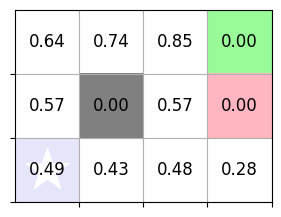

In [75]:
# Using provided utilities, we can print the state values of the Grid World!
_, _ = plot_grid(GRID_MDP.grid, qtable)

#### Notes

**Vectorized implementation**: This is clearly not an optimal implementation, but it is good for
understanding the algorithm. For an optimized algorithm, we should vectorize states, actions, and
use a vectorized implementation. Something along the lines of:

```python
    new_value = np.max(np.sum(transitions * (rewards + gamma * old_value), axis=2), axis=1)
```

**Convergence**: Value iteration (as well as policy iteration, see below) are proven to converge.
Check out the materials linked in the Intro in case you are interested.

**Policy Iteration**: Another exect solution algorithm (one "policy evaluation" step to find state
values, followed by "policy improvement"). It is usually faster (see linked resources).

### Optimal Policy

Got the optimal value function, and now? Well, we are in luck: an optimal policy is the one that chooses the action with higher value!

$$
\pi^*(s) = \argmax_a Q^*(s, a)
$$

In [76]:
optimal_policy = lambda s: qtable.best_action(s)

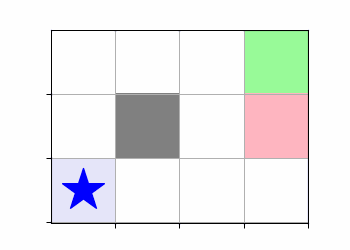

In [77]:
# Let's see how an optimal agent behaves!
init_random()
run_simulation(GRID_MDP, optimal_policy)

## Aren't We Done?! :)

Fortunately for our own amusement, we are not! There are two major very practical limitations:

 1. We rarely (almost never!) have access to the MDP transition model.
 2. The state and action space are generally large and not tractable this way.

The first point is what classic reinforcement learning algorithms address: enable the agent to find
an optimal policy just from interacting with (i.e., sampling) the environment. The second category
is addressed by deep reinforcement learning! Keep going and have fun!

### Grid World Environment

The _environment_ is what the agent will use in reinforcement learning algorithms.

In [100]:
import numpy as np

class GridEnv:
    """A reinforcement learning environment to interact with the Grid World and sample from it."""

    def __init__(self, mdp: GridMDP):
        """Initializes the GridEnv."""
        self.mdp = mdp
        self.state = mdp.start
        self.terminated = False

    def reset(self) -> State:
        """Resets the state to the start state, not terminated, and returns the new start state."""
        self.state = self.mdp.start
        self.terminated = False
        return self.state

    def step(self, action: Action) -> tuple[State, float, bool]:
        """Performs a step in the environment given the selected `action` by the agent.

        Returns a tuple of (next_state, reward, is_done), with the next state after the action has
        been taked, the associated reward, and whether the episode terminated.
        """

        if self.terminated:
            raise Exception('Environment episode completed, please call reset.')

        # TODO: Compute the state probabilities for the action, sample the probabilities to select
        #       the next state, calculate the reward, determine if the next_state is terminal, and
        #       return the tuple (next_state, reward, done).

        present_state = self.state

        next_state_probs = self.mdp.transition(present_state, action)
        next_state = list(next_state_probs.keys())[0]
        prob = next_state_probs[next_state]

        reward = self.mdp.reward(present_state, action, next_state)

        is_terminal = self.mdp.is_terminal(next_state)
        self.state = next_state

        self.terminated = is_terminal

        return (next_state, reward, is_terminal)

In [101]:
# Test your implementation!
init_random()

GRID_ENV = GridEnv(GridMDP(WORLD_GRID))

assert not GRID_ENV.terminated

assert GRID_ENV.step(Action.UP) == (State(0, 1), 0.0, False)
assert GRID_ENV.state == State(0, 1)

assert GRID_ENV.step(Action.UP) == (State(0, 2), 0.0, False)
assert GRID_ENV.state == State(0, 2)

GRID_ENV.terminated = True
assert GRID_ENV.reset() == State()
assert GRID_ENV.state == State()
assert GRID_ENV.terminated == False

GRID_ENV.step(Action.UP)
GRID_ENV.step(Action.UP)
GRID_ENV.step(Action.RIGHT)

assert GRID_ENV.step(Action.RIGHT) == (State(2, 2), 0.0, False)
assert GRID_ENV.step(Action.RIGHT) == (State(3, 2), 1.0, True)
assert GRID_ENV.terminated


## Appendix

### Noise and Discount Tradeoff

Consider the cliff-world grid:

In [ ]:
from util.gridworld import Grid

# N has -10 return, G has +10 return.
CLIFF_WORLD_GRID = Grid([
    'EEEEE',
    'EWEEE',
    'EWTWG',
    'SEEEE',
    'NNNNN',
])

plot_grid(CLIFF_WORLD_GRID, agent_pos=(0, 1))

Try to solve the environment with different values of $\gamma$ (e.g., `0.1` and `0.99`) and _noise_
(e.g., `0` and `0.5`). When does the agent prefers the shortest path? What about the closer exit?
When does it risk the cliff?

### Extensions

There are extensions to MDP such as POMDP (Partially Observable MDP) and HMM (Hidden Markov Models)
that are interesting areas to explore and learn about as well!